In [20]:
import pandas as pd
import numpy as np
import requests
import re
import seaborn
import matplotlib.pyplot as plt
import tensorflow as tf
import warnings
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
warnings.filterwarnings('ignore')

In [21]:
dataset = pd.read_csv('sonidosEtiquetados.csv')
dataset.head()

,frecuencia1,ugen1,frecuencia2,ugen2,frecuencia3,ugen3,clase
0,16838,9,7579,4,12851,0,0
1,5031,8,8673,4,11376,9,1
2,10285,2,10089,5,17702,9,1
3,1779,9,7285,8,2744,8,2
4,16730,7,4083,2,4379,11,0


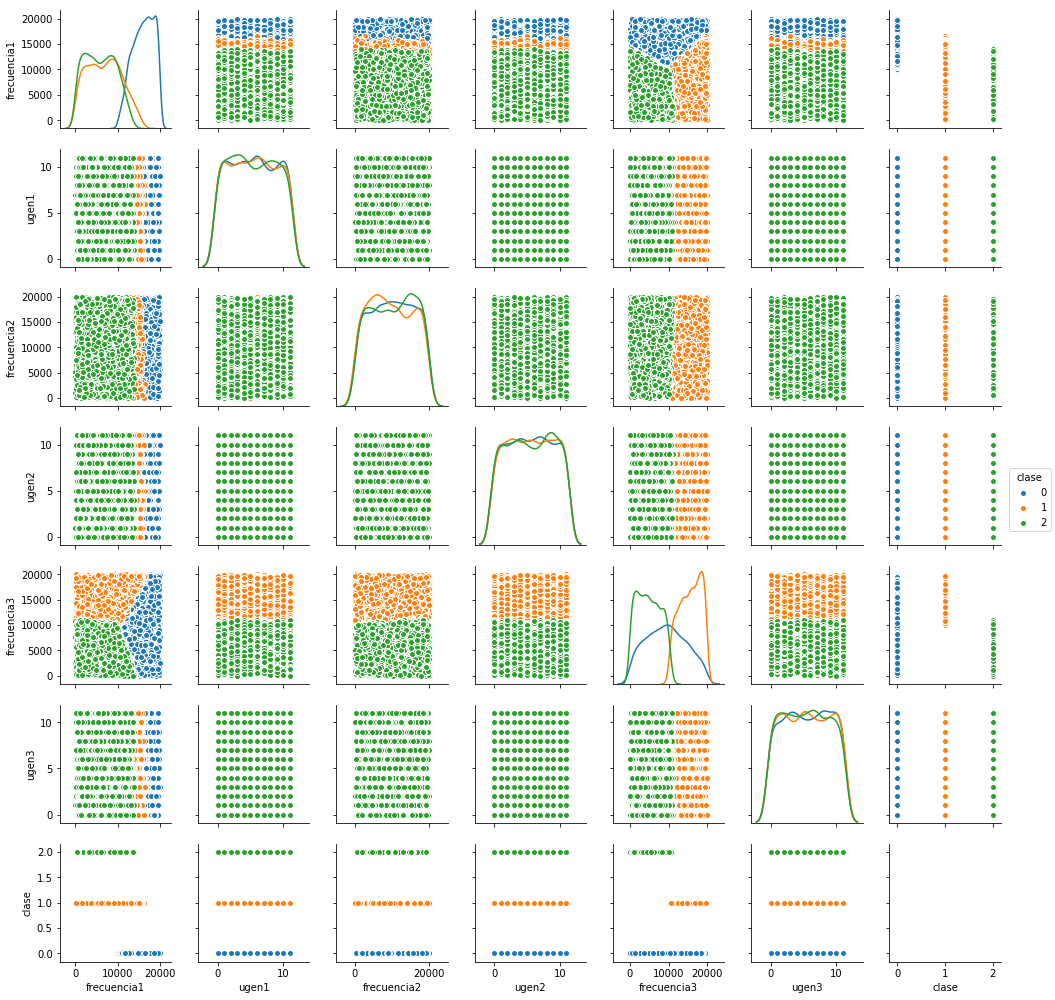

In [22]:
seaborn.pairplot(dataset, hue="clase", size=2, diag_kind="kde")
plt.show()

In [5]:
species_lb = LabelBinarizer()
Y = species_lb.fit_transform(dataset.clase.values)

In [6]:
FEATURES = dataset.columns[0:6]
X_data = dataset[FEATURES].as_matrix()
X_data = normalize(X_data)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X_data, Y, test_size=0.3, random_state=1)
X_train.shape

(7000, 6)

In [8]:
# Parameters
learning_rate = 0.01
training_epochs = 100

In [9]:
# Neural Network Parameters
n_hidden_1 = 256 # 1st layer number of neurons
n_hidden_2 = 128 # 1st layer number of neurons
n_input = X_train.shape[1] # input shape (7000, 6)
n_classes = y_train.shape[1] # classes to predict

In [10]:
# Inputs
X = tf.placeholder("float", shape=[None, n_input])
y = tf.placeholder("float", shape=[None, n_classes])

# Dictionary of Weights and Biases
weights = {
  'h1': tf.Variable(tf.random_normal([n_input, n_hidden_1])),
  'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
  'out': tf.Variable(tf.random_normal([n_hidden_2, n_classes]))
}

biases = {
  'b1': tf.Variable(tf.random_normal([n_hidden_1])),
  'b2': tf.Variable(tf.random_normal([n_hidden_2])),
  'out': tf.Variable(tf.random_normal([n_classes]))
}

In [11]:
# Model Forward Propagation step
def forward_propagation(x):
    # Hidden layer1
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1'])
    layer_1 = tf.nn.relu(layer_1)
    
    layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2'])
    layer_2 = tf.nn.relu(layer_2)

    # Output fully connected layer
    out_layer = tf.matmul(layer_2, weights['out']) + biases['out'] 
    return out_layer


# Model Outputs
yhat = forward_propagation(X)
ypredict = tf.argmax(yhat, axis=1)

In [12]:
# Backward propagation
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=yhat))
optimizer = tf.train.GradientDescentOptimizer(learning_rate)
#optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

train_op = optimizer.minimize(cost)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [13]:
# Initializing the variables
init = tf.global_variables_initializer()

from datetime import datetime
startTime = datetime.now()

with tf.Session() as sess:
    sess.run(init)
    
    #writer.add_graph(sess.graph)
    #EPOCHS
    for epoch in range(training_epochs):
        #Stochasting Gradient Descent
        for i in range(len(X_train)):
            summary = sess.run(train_op, feed_dict={X: X_train[i: i + 1], y: y_train[i: i + 1]})
        
        train_accuracy = np.mean(np.argmax(y_train, axis=1) == sess.run(ypredict, feed_dict={X: X_train, y: y_train}))
        test_accuracy  = np.mean(np.argmax(y_test, axis=1) == sess.run(ypredict, feed_dict={X: X_test, y: y_test}))
                
        print("Epoch = %d, train accuracy = %.2f%%, test accuracy = %.2f%%" % (epoch + 1, 100. * train_accuracy, 100. * test_accuracy))
        #print("Epoch = %d, train accuracy = %.2f%%" % (epoch + 1, 100. * train_accuracy))

    sess.close()
print("Time taken:", datetime.now() - startTime)

Epoch = 1, train accuracy = 73.66%, test accuracy = 74.83%
Epoch = 2, train accuracy = 74.81%, test accuracy = 75.60%
Epoch = 3, train accuracy = 76.44%, test accuracy = 77.03%
Epoch = 4, train accuracy = 77.11%, test accuracy = 77.70%
Epoch = 5, train accuracy = 77.53%, test accuracy = 77.47%
Epoch = 6, train accuracy = 77.67%, test accuracy = 77.83%
Epoch = 7, train accuracy = 78.16%, test accuracy = 78.40%
Epoch = 8, train accuracy = 77.59%, test accuracy = 77.67%
Epoch = 9, train accuracy = 77.01%, test accuracy = 76.33%
Epoch = 10, train accuracy = 77.14%, test accuracy = 76.23%
Epoch = 11, train accuracy = 78.31%, test accuracy = 78.80%
Epoch = 12, train accuracy = 79.53%, test accuracy = 79.93%
Epoch = 13, train accuracy = 79.56%, test accuracy = 80.03%
Epoch = 14, train accuracy = 78.74%, test accuracy = 79.27%
Epoch = 15, train accuracy = 78.90%, test accuracy = 78.93%
Epoch = 16, train accuracy = 78.67%, test accuracy = 78.80%
Epoch = 17, train accuracy = 79.20%, test accurac

In [26]:
#predicción

#yhat = forward_propagation([16838,9,7579,4,12851,0])
#ypredict = tf.argmax(yhat, axis=1)
with tf.Session() as sess:
    tf.global_variables_initializer().run()    
    feed_dict = {X: [[17921,5,9524,6,6720,5]]}
    classification = sess.run(ypredict, feed_dict)
    print(classification)

[2]
